# Fully Supervised Framework Evaluation 
This is an notebook attempting to replicate the results of the fully supervised framework evaluation process proposed in the TypiClust paper. 

As following the paper, the budget size will be 10 (equal to the number of classes in CIFAR10). The initial labelled set L₀ was empty (∅), requiring initial pooling. With all sampling methods being compared over 5 iterative query rounds. The test/validation accuracy will be average across 10 repetitions. Enabling careful testing of how each sampling method behaves in low-budget AL scenarios. 

The follow training configurations are also followed: 

Model: ResNet18 trained on the labeled set.
Optimizer: SGD with 0.9 momentum and Nesterov acceleration.
Learning rate: Initialised at 0.025, adjusted via cosine scheduler. Epoch = 100

Data Augmentation: Random crops and horizontal flips.


This notebook will be comparing random, TypiClust and TypiclustPlus performances and evaluating them.

There is also an option to save each result locally as a JSON file. This is the format of the JSON file: 

```json
{
  "rep 0": [
    {
      "val iter 0 acc/loss": [float, float],
      "val iter 1 acc/loss": [float, float],
      ...
      "val iter i acc/loss": [float, float]
    },
    {
      "train iter 0": [
        (epoch float, accuracy float), 
        ... 
        (epoch float, accuracy float)
      ],
      "train iter 1": [
        (epoch float, accuracy float), 
        ... 
        (epoch float, accuracy float)
      ],
      ...
      "train iter i": [
        (epoch float, accuracy float), 
        ... 
        (epoch float, accuracy float)
      ]
    }
  ]
}

```

- The outermost key `"rep 0"` represents a specific training run or repetition.
- The first object within `"rep 0"` contains validation results with keys like `"val iter 0 acc/loss"` storing accuracy and loss as `[float, float]`.
- The second object contains training results for different iterations, with each key like `"train iter 0"` storing a list of tuples representing `(epoch, accuracy)`.


# Imports 

In [ ]:
import torchvision 
import torch 
import torch.nn as nn
import numpy as np 
import json 
import matplotlib.pyplot as plt 

from typiclust import Typiclust
from typiclustPlus import TypiclustPlus
import random

random.seed(42)
torch.cuda.is_available()

True

# Variables and Setup 

Following the implementation details in the paper, during this active learning evaluation process, some transformations will be applied to the training data. 

In [18]:
DEVICE = torch.device('cuda')
LR = 0.025
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0003 
NESTEROV = True
DATA_DIR = "./datasets"
BUDGET_SIZE = 10 
N_REPS = 10
ITERATIONS = 5 
EPOCHS = 100

In [19]:
# Define CIFAR-10 data transforms with augmentations
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ]) 

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [20]:
dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, 
                                       train=True, 
                                       download=True, 
                                       transform=train_transform)

testset = torchvision.datasets.CIFAR10(root=DATA_DIR, 
                                       train=False, 
                                       download=True, 
                                       transform=test_transform)

test_loader = torch.utils.data.DataLoader(
            testset, batch_size=BUDGET_SIZE, shuffle=False,
            num_workers=0, pin_memory=True, drop_last=False)

### Resnet18

In [21]:
def init_resnet():
    """Initalise Resnet18 for fully-supervised AL"""
    model = torchvision.models.resnet18(weights=None)

    # Modify FC layer for 10 CIFAR-10 classes
    model.fc = nn.Linear(512, out_features=10)  
    model = model.to(DEVICE)

    # SGD 
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=LR,
                                momentum=MOMENTUM,
                                weight_decay=WEIGHT_DECAY,
                                nesterov=NESTEROV)
    
    # Cosine scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) 

    # Cross Entropy Loss 
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, scheduler, criterion

def accuracy(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute accuracy for resnet given outputs as logits"""
    preds = torch.argmax(outputs, dim=1)
    return torch.sum(preds == labels) / len(preds)

def train(model, optimizer, scheduler, criterion, data_loader, epochs):
    """Train resnet18"""
    model.train()

    # Accuracy for each Epoch 
    train_accuracies = []

    for epoch in range(epochs):
        running_acc = 0.0

        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Compute predictions 
            outputs = model(inputs)  # predicted class
            loss = criterion(outputs, labels)

            # Compute training accuracy
            running_acc += accuracy(outputs, labels)

            # Perform backpropagation
            loss.backward()  # compute gradients
            optimizer.step()  # update model parameters

        scheduler.step()

        train_accuracy = (running_acc / len(data_loader)).item()
        train_accuracies.append((epoch, train_accuracy))
    return train_accuracies

def eval(model, test_loader, criterion):
    """Evaluate model on CIFAR10 validation set"""
    model.eval()  # set model to evaluation
    
    running_vloss = 0.0
    with torch.no_grad():
        running_val_acc = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_vloss += loss.item()

            # Compute validation accuracy
            running_val_acc += accuracy(outputs, labels)

    val_accuracy = (running_val_acc / len(test_loader)).item()
    avg_vloss = (running_vloss / len(test_loader))
    
    print(f"Val acc: {round(val_accuracy*100, 2)}% | Avg Val Loss: {round(avg_vloss, 4)}")
    return [val_accuracy, avg_vloss]
    

# Random Sampling

### Functions 

In [22]:
def random_sample(dataset, budget_size, l_set_indices):
    """
    Random sampling 
    
    Args: 
    dataset (torchvision.datasets): CIFAR10 training dataset 
    budget_size (int): sample size 
    l_set_indices List[int]: labelled data points indices 

    Returns: 
    l_set (torch.utils.data.Subset) : Labelled dataset 
    l_set_indices List[int]: Updated labelled data points indices 
    """

    # Shuffle un-labelled dataset 
    tempIdx = [i for i in range(len(dataset))]
    ids = list(set(tempIdx) - set(l_set_indices))
    np.random.shuffle(ids)

    # Add to unlabelled-set 
    l_set_indices+= ids[0:budget_size]
    l_set = torch.utils.data.Subset(dataset,  l_set_indices)

    return l_set, l_set_indices

In [23]:
def random_al(budget_size, iterations, epochs):
    """
    Random Sampling Active Learning Loop for n iterations
    """
    l_set_indices = []

    print("---Initial Pooling / L0 Set Extraction--")
    l_set, l_set_indices = random_sample(dataset,
                                budget_size, 
                                l_set_indices)

    print("--Loading model--")
    model, optimizer, scheduler, criterion = init_resnet()

    print("--Starting Active Learning--")
    train_results = {}
    val_results = {}
    
    # Active learning iterations 
    for i in range(iterations+1):
        print(f"Iteration {i+1}:")
        print(f"L set size: {len(l_set_indices)}")
        print(f"L set indices: {l_set_indices}")

        # Load labelled dataset 
        l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=budget_size, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False)

        # Train for n epochs 
        train_accuracies = train(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            scheduler=scheduler,
            data_loader=l_set_loader,
            epochs=epochs)
        
        # Evaluate current model 
        val_accuracies = eval(model, 
                              test_loader, 
                              criterion=criterion, 
                              )
        
        # Add results 
        val_results[f'val iter {i} acc/loss'] = val_accuracies
        train_results[f'train iter {i} acc'] = train_accuracies

        if i != iterations:
            l_set, l_set_indices = random_sample(dataset, 
                                             budget_size, 
                                             l_set_indices)
        print("\n\n")
    return val_results, train_results 


### Active Learning Loop 


In [24]:
random_results = {}

for rep in range(N_REPS):
    print(f"---Repetition {rep+1}---")
    val_acc, train_acc = random_al(budget_size=BUDGET_SIZE,
                                   iterations=ITERATIONS,
                                   epochs=EPOCHS,
                                    )
    
    random_results[f'rep {rep}'] = (val_acc, train_acc)

---Repetition 1---
---Initial Pooling / L0 Set Extraction--
--Loading model--
--Starting Active Learning--
Iteration 1:
L set size: 10
L set indices: [36629, 23828, 31490, 48664, 46560, 32229, 4978, 40695, 9213, 28086]
Val acc: 10.85% | Avg Val Loss: 8.0277



Iteration 2:
L set size: 20
L set indices: [36629, 23828, 31490, 48664, 46560, 32229, 4978, 40695, 9213, 28086, 48001, 30360, 25593, 7790, 36561, 7114, 15397, 30534, 15363, 15959]
Val acc: 16.58% | Avg Val Loss: 4.5933



Iteration 3:
L set size: 30
L set indices: [36629, 23828, 31490, 48664, 46560, 32229, 4978, 40695, 9213, 28086, 48001, 30360, 25593, 7790, 36561, 7114, 15397, 30534, 15363, 15959, 1358, 18589, 44128, 11862, 44053, 10341, 765, 43178, 13026, 41202]
Val acc: 21.3% | Avg Val Loss: 3.6206



Iteration 4:
L set size: 40
L set indices: [36629, 23828, 31490, 48664, 46560, 32229, 4978, 40695, 9213, 28086, 48001, 30360, 25593, 7790, 36561, 7114, 15397, 30534, 15363, 15959, 1358, 18589, 44128, 11862, 44053, 10341, 765, 431

### Save Locally 

In [ ]:
out_file = open(f"{DATA_DIR}/random_fully_supervised.json", "w")
json.dump(random_results, out_file, indent = 6)
out_file.close()

# TypiClust 

### Functions 

In [26]:
def typi_al(budget_size, iterations, epochs):
    """
    Typiclust Sampling Active Learning Loop for n iterations
    """
    l_set_indices = []
    
    # Feature Representational Learning dataset 
    feat_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, 
                                           train=True, 
                                           download=True, 
                                           transform=test_transform)

    feat_loader = torch.utils.data.DataLoader(
        feat_ds, batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False
    )

    # Typiclust Arguments 
    args = {
            'data_dir' : DATA_DIR, 
            'dataset_name' : 'cifar10',
            'device' : DEVICE,
        }
    
    print("---Initial Pooling / L0 Set Extraction--")
    tpc = Typiclust(dataset,
                    feat_loader,
                    budget_size,
                    l_set_indices,
                    args)
    
    print(f"Sampling {budget_size} samples...")
    l_set, l_set_indices= tpc.sample(l_set_indices)
    
    print("--Loading model--")
    model, optimizer, scheduler, criterion = init_resnet()

    print("--Starting Active Learning--")
    train_results = {}
    val_results = {}

    # Active learning iterations 
    for i in range(iterations+1):
        print(f"Iteration {i+1}:")
        print(f"L set size: {len(l_set_indices)}")
        print(f"L set indices: {l_set_indices}")
        
        # Load labelled dataset
        l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=10, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False)

        # Train
        train_accuracies = train(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            scheduler=scheduler,
            data_loader=l_set_loader,
            epochs=epochs)

        # Evaluate 
        val_accuracies = eval(model, test_loader, criterion=criterion)

        # Add results 
        val_results[f'val iter {i} acc/loss'] = val_accuracies
        train_results[f'train iter {i} acc'] = train_accuracies

        if i != iterations:
            print(f"Sampling {budget_size} samples...")
            l_set, l_set_indices= tpc.sample(l_set_indices)

        print("\n\n")
    return val_results, train_results 

### Active Learning Loop

In [27]:
typi_results = {}

# Repeat Active Learning for n times 
for rep in range(N_REPS):
    print(f"---Repetition {rep+1}---")
    val_acc, train_acc = typi_al(budget_size=BUDGET_SIZE,
                                   iterations=ITERATIONS,
                                   epochs=EPOCHS,
                                )
    typi_results[f'rep {rep}'] = (val_acc, train_acc)

---Repetition 1---
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 samples...
Loaded typiclust_cifar10_budget_10.npy locally...
--Loading model--
--Starting Active Learning--
Iteration 1:
L set size: 10
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102]
Val acc: 15.09% | Avg Val Loss: 6.5108
Sampling 10 samples...
Loaded typiclust_cifar10_budget_20.npy locally...



Iteration 2:
L set size: 20
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102, 4545, 12091, 15790, 29674, 26956, 29435, 15481, 11418, 31146, 48099]
Val acc: 17.96% | Avg Val Loss: 4.1848
Sampling 10 samples...
Loaded typiclust_cifar10_budget_30.npy locally...



Iteration 3:
L set size: 30
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102, 4545, 12091, 15790, 29674, 26956, 29435, 15481, 11418, 31146, 48099, 25826, 18699, 7429, 10673, 7250, 18860, 1959, 38926, 43423, 16831]
Val acc: 20.83% | Avg 

### Save Locally 

In [ ]:
out_file = open(f"{DATA_DIR}/typiclust_fully_supervised.json", "w")
json.dump(typi_results, out_file, indent = 6)
out_file.close()

# TypiclustPlus

### Functions 

In [29]:
def typiplus_al(budget_size, iterations, epochs):
    l_set_indices = []
    
    # Active learning iterations 
    feat_ds = torchvision.datasets.CIFAR10(root=DATA_DIR, 
                                           train=True, 
                                           download=True, 
                                           transform=test_transform)

    feat_loader = torch.utils.data.DataLoader(
        feat_ds, batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False
    )
    
    # TypiclustPlus arguments 
    args = {
            'data_dir' : DATA_DIR, 
            'dataset_name' : 'cifar10',
            'device' : DEVICE,
            'alpha' : 1.0,
            'beta' : 1.0,
            'gamma' : 0.01,
        }
    
    print("---Initial Pooling / L0 Set Extraction--")
    tpc = TypiclustPlus(dataset,
                    feat_loader,
                    budget_size,
                    l_set_indices,
                    args)
    
    print(f"Sampling {budget_size} samples...")
    l_set, l_set_indices= tpc.sample(l_set_indices)
    
    print("--Loading model--")
    model, optimizer, scheduler, criterion = init_resnet()


    print("--Starting Active Learning--")
    train_results = {}
    val_results = {}

    # Active learning iterations 
    for i in range(iterations+1):
        print(f"Iteration {i+1}:")
        print(f"L set size: {len(l_set_indices)}")
        print(f"L set indices: {l_set_indices}")
        
        # Load labelled dataset
        l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=10, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False)
    
        # Train 
        train_accuracies = train(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            scheduler=scheduler,
            data_loader=l_set_loader,
            epochs=epochs)

        # Validation 
        val_accuracies = eval(model, 
                              test_loader, 
                              criterion)

        # Add results 
        val_results[f'val iter {i} acc/loss'] = val_accuracies
        train_results[f'train iter {i} acc'] = train_accuracies

        if i != iterations:
            print(f"Sampling {budget_size} samples...")
            l_set, l_set_indices= tpc.sample(l_set_indices)

        print("\n\n")
    return val_results, train_results 

### Active Learning Loop

In [32]:
typiplus_results = {}
for rep in range(N_REPS):
    print(f"---Repetition {rep+1}---")
    val_acc, train_acc = typiplus_al(budget_size=BUDGET_SIZE,
                                   iterations=ITERATIONS,
                                   epochs=EPOCHS,
                                )
    typiplus_results[f'rep {rep}'] = (val_acc, train_acc)

---Repetition 1---
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 samples...
Loaded typiclustplus_cifar10_budget_10.npy locally...
--Loading model--
--Starting Active Learning--
Iteration 1:
L set size: 10
L set indices: [38604, 36281, 26075, 13534, 19334, 8133, 30564, 48308, 8304, 4410]
Val acc: 11.74% | Avg Val Loss: 6.9246
Sampling 10 samples...
Loaded typiclustplus_cifar10_budget_20.npy locally...



Iteration 2:
L set size: 20
L set indices: [38604, 36281, 26075, 13534, 19334, 8133, 30564, 48308, 8304, 4410, 10365, 11995, 33011, 21084, 38572, 12225, 1738, 35596, 18989, 15966]
Val acc: 19.02% | Avg Val Loss: 5.2761
Sampling 10 samples...
Loaded typiclustplus_cifar10_budget_30.npy locally...



Iteration 3:
L set size: 30
L set indices: [38604, 36281, 26075, 13534, 19334, 8133, 30564, 48308, 8304, 4410, 10365, 11995, 33011, 21084, 38572, 12225, 1738, 35596, 18989, 15966, 4056, 15837, 47183, 11038, 48063, 48591, 48966, 1106, 19480, 46014]
Val acc: 19.

### Save Locally 

In [ ]:
out_file = open(f"{DATA_DIR}/typiclustplus_fully_supervised.json", "w")
json.dump(typiplus_results, out_file, indent = 6)
out_file.close()

# Plots 

If you have previously saved results as JSON, you can load them in. Though this is un-needed if the whole notebook has been previously executed in this run time. 

In [ ]:
# OPTIONAL 
f = open(f"{DATA_DIR}/typiclustplus_fully_supervised.json")
typiplus_results = json.load(f)

f = open(f"{DATA_DIR}/random_fully_supervised.json")
random_results = json.load(f)

f = open(f"{DATA_DIR}/typiclust_fully_supervised.json")
typi_results = json.load(f)

Collate all results and calculate the means and standard deviations of each budget size for each sampling technique experimented with. 

In [ ]:
from scipy import stats
import scikit_posthocs
a = 0.05 

# Map sampling technique to the results collected from the AL iterations
sample_results = {"TypiClust" : typi_results,
                  "TypiClust Plus" : typiplus_results,
                  "Random" : random_results}

sample_kruskal = [] 
sample_means = []
sample_stds = []

# Loop through all sampling technique results 
for __, result in sample_results.items():
    budget_size_val_accuracies = [[] for i in range(ITERATIONS+1)]

    # Collect all validation accuarcies for each budget size 
    for rep, values in result.items():
        iter_count = 0 
        for iter, val_metrics in values[0].items():
            val_acc = val_metrics[0]
            budget_size_val_accuracies[iter_count].append(val_acc)
            iter_count += 1 
    sample_kruskal.append(budget_size_val_accuracies)

    # Calculate the mean and std for each budget size 
    budget_size_means = np.array([np.mean(b)*100 for b in budget_size_val_accuracies])
    budget_size_stds = np.array([np.std(b)*100 for b in budget_size_val_accuracies])

    # Add sample technique means/std to a list of all techniques used 
    sample_means.append(budget_size_means)
    sample_stds.append(budget_size_stds)

# Statistical Analysis 
print(f"Kruskal-Wallis P-value test w/ Post hoc\nSig level:{a}")
for i in range(ITERATIONS+1):
    typi = sample_kruskal[0][i]
    typiplus = sample_kruskal[1][i]
    random = sample_kruskal[2][i]
    print("---------")
    print(f"Budget {i*10+10} P-Value: {(stats.kruskal(typi, typiplus, random)[-1])}\n")

    post_hoc = scikit_posthocs.posthoc_dunn([typi,typiplus,random])
    print("Post hoc Dunn's test")
    print(post_hoc)
    print('\n\n')

Kruskal-Wallis P-value test w/ Post hoc
Sig level:0.05
---------
Budget 10 P-Value: 0.00045253513053775704

Post hoc Dunn's test
          1         2         3
1  1.000000  0.000113  0.186568
2  0.000113  1.000000  0.011085
3  0.186568  0.011085  1.000000



---------
Budget 20 P-Value: 0.00203205094663085

Post hoc Dunn's test
          1         2         3
1  1.000000  0.002725  0.001943
2  0.002725  1.000000  0.919074
3  0.001943  0.919074  1.000000



---------
Budget 30 P-Value: 0.006966873047698398

Post hoc Dunn's test
          1         2         3
1  1.000000  0.004807  0.008559
2  0.004807  1.000000  0.848901
3  0.008559  0.848901  1.000000



---------
Budget 40 P-Value: 0.002946619275239471

Post hoc Dunn's test
          1         2         3
1  1.000000  0.053557  0.000665
2  0.053557  1.000000  0.140697
3  0.000665  0.140697  1.000000



---------
Budget 50 P-Value: 0.0004319949004975984

Post hoc Dunn's test
          1         2         3
1  1.000000  0.115302  0.01

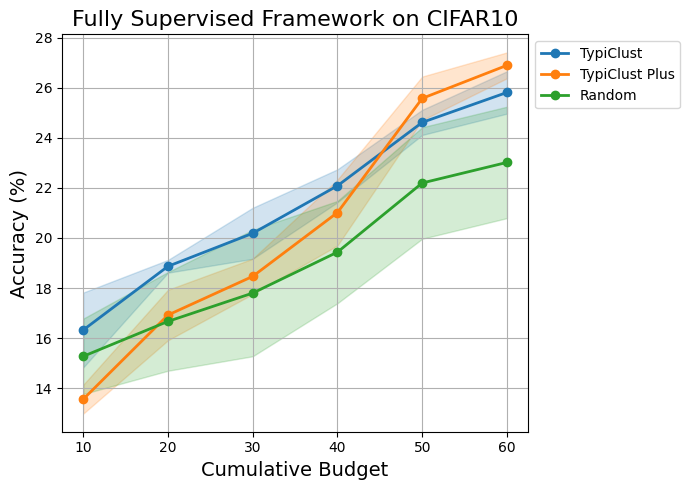

In [16]:
# X-axis labels 
cumulative_budget = np.linspace(10, 60, 6)

# Plotting
plt.figure(figsize=(7, 5))

colors = plt.cm.tab20.colors  # Use a colormap for variety

# Plot for each sampling technique 
for i, (mean, std) in enumerate(zip(sample_means, sample_stds)):
    # Plot mean 
    plt.plot(cumulative_budget, 
             mean, 
             color=colors[2*i], 
             marker='o', 
             linewidth=2, 
             label=list(sample_results.keys())[i])
    
    # Plot variance 
    plt.fill_between(cumulative_budget, mean - std, mean + std, color=colors[2*i], alpha=0.2)

# Labels and Legend
plt.xlabel('Cumulative Budget', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Fully Supervised Framework on CIFAR10', fontsize=16)
plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()